# Модель для предсказания уровня зарплатных ожиданий сотрудников

## Импорты

In [ ]:
!pip install catboost

In [ ]:
# Вычисления и анализ
import numpy as np
import pandas as pd

# Хранение и загрузка постоянных данных
from google.colab import drive

# Визуализация данных
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

# Утилиты и препроцессинг
import random
import warnings
from sklearn.utils import shuffle
from prettytable import PrettyTable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Модели и метрики
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error as mae

# Воспроизводимость и продакшн
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Исходные данные

In [ ]:
drive.mount('/content/drive')
wdir = '/content/drive/My Drive/Courses/DataScience/DataScience/I_DIPLOMA/data'

Mounted at /content/drive


In [ ]:
raw_data = pd.read_excel(f'{wdir}/raw_data2.xlsx')

In [ ]:
raw_data.head(3)

,Unnamed: 0,entrydate,title,position,gender,city,age,salary,experience,last_job,updated,link
0,1,2020-04-08,Резюме Менеджер по работе с клиентами,Клиентский менеджер,Мужчина,Санкт-Петербург,32,70,6.0,Tyllypad,2020-04-08,https://hh.ru/resume/5758d20c0001e99d4b0039ed1...
1,2,2020-04-09,Резюме Региональный представитель по продажам,Региональный менеджер,Мужчина,Москва,29,75,5.0,"ООО «Альфа-М""",2020-04-05,https://hh.ru/resume/1149379e0003c515530039ed1...
2,3,2020-04-09,Резюме Региональный менеджер по продажам,Региональный менеджер,Мужчина,Ессентуки,46,70,13.0,ООО Опт-Сервис КМВ,2020-04-07,https://hh.ru/resume/95d91bd900055096170039ed1...


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  9909 non-null   int64         
 1   entrydate   9909 non-null   datetime64[ns]
 2   title       9909 non-null   object        
 3   position    9909 non-null   object        
 4   gender      9909 non-null   object        
 5   city        9909 non-null   object        
 6   age         9909 non-null   int64         
 7   salary      9909 non-null   int64         
 8   experience  7951 non-null   float64       
 9   last_job    9909 non-null   object        
 10  updated     9909 non-null   datetime64[ns]
 11  link        9909 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 929.1+ KB


In [ ]:
raw_data.columns

Index(['Unnamed: 0', 'entrydate', 'title', 'position', 'gender', 'city', 'age',
       'salary', 'experience', 'last_job', 'updated', 'link'],
      dtype='object')

## Предобработка данных

In [ ]:
def data_prep(df_input):
  """Обрабатывает исходные данные"""
  df_output = df_input.copy()
  df_output['experience'] = df_output['experience'].fillna(
                            df_output['experience'].mean())
  df_output['experience'] = df_output['experience'].astype(np.int)
  df_output.drop([
                  'Unnamed: 0',
                  'title',
                  'entrydate',
                  'last_job',
                  'updated',
                  'link'],
                 axis=1,
                 inplace=True)
  
  return df_output

In [ ]:
# Посмотрим на подготовленные данные
data = data_prep(raw_data)
data.head()

,position,gender,city,age,salary,experience
0,Клиентский менеджер,Мужчина,Санкт-Петербург,32,70,6
1,Региональный менеджер,Мужчина,Москва,29,75,5
2,Региональный менеджер,Мужчина,Ессентуки,46,70,13
3,Менеджер по продажам,Мужчина,Москва,20,70,11
4,Клиентский менеджер,Мужчина,Москва,33,55,10


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    9909 non-null   object
 1   gender      9909 non-null   object
 2   city        9909 non-null   object
 3   age         9909 non-null   int64 
 4   salary      9909 non-null   int64 
 5   experience  9909 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 464.6+ KB


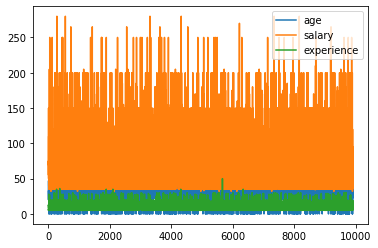

In [ ]:
# Посмотрим, есть ли в данных выбросы
data.plot();

In [ ]:
data[data['salary'] > 200]

,position,gender,city,age,salary,experience
31,Менеджер по развитию,Женщина,Москва,0,205,13
43,Руководитель продаж,Мужчина,Москва,51,250,11
123,Руководитель продаж,Мужчина,Москва,51,250,11
276,Коммерческий директор,Мужчина,Москва,42,280,11
280,Руководитель продаж,Мужчина,Москва,39,250,16
...,...,...,...,...,...,...
9199,Коммерческий директор,Мужчина,Москва,36,265,12
9517,Менеджер по развитию,Женщина,Москва,0,205,13
9625,Коммерческий директор,Мужчина,Москва,35,250,12
9761,Коммерческий директор,Мужчина,Москва,48,250,11


Пожалуй, все позиции кроме "Руководитель продаж" и "Коммерческий директор" с ожиданиями выше 200 тыс.руб - будут вносить "разлад" в наши данные. Удалим их

In [ ]:
 isx = data[
      (data['salary'] > 200) & 
      (data['position'] != 'Коммерческий директор') &
      (data['position'] != 'Руководитель продаж')].index

data = data.drop(data.index[isx])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9894 entries, 0 to 9908
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    9894 non-null   object
 1   gender      9894 non-null   object
 2   city        9894 non-null   object
 3   age         9894 non-null   int64 
 4   salary      9894 non-null   int64 
 5   experience  9894 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 541.1+ KB


## Feature Engineering

Обогатим наши данные численностью населения в городах проживания кандидатов, источник данных: https://zema.su/blog/polnyi-spisok-vsekh-gorodov-rossii-po-chislennosti-naseleniya

In [ ]:
cities = pd.read_excel(f'{wdir}/cities.xlsx')
cities = cities.drop('Н', axis=1)
cities.columns = ['city', 'population']
cities.head()

,city,population
0,Москва,11514330
1,Санкт-Петербург,4848742
2,Новосибирск,1473737
3,Екатеринбург,1350136
4,Нижний Новгород,1250615


In [ ]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   city        1109 non-null   object
 1   population  1109 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.5+ KB


In [ ]:
# Добавим данные по численности к основному датасету
data_merged = data.merge(cities, how='left', left_on='city', right_on='city')
data_merged.head()

,position,gender,city,age,salary,experience,population
0,Клиентский менеджер,Мужчина,Санкт-Петербург,32,70,6,4848742.0
1,Региональный менеджер,Мужчина,Москва,29,75,5,11514330.0
2,Региональный менеджер,Мужчина,Ессентуки,46,70,13,100969.0
3,Менеджер по продажам,Мужчина,Москва,20,70,11,11514330.0
4,Клиентский менеджер,Мужчина,Москва,33,55,10,11514330.0


In [ ]:
# Посмотрим % пропусков в столбце "population"
empty_values = data_merged['population'].isna().sum() / len (data_merged) * 100
print(f'{round(empty_values, 2)}%')

5.96%


In [ ]:
# Пропуски есть, но не критично много
# заполним их средними значениями
data_merged['population'] = data_merged['population'].fillna(
                            data_merged['population'].mean())
# И преобразуем float к int
data_merged['population'] = data_merged['population'].astype(np.int)
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9894 entries, 0 to 9893
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    9894 non-null   object
 1   gender      9894 non-null   object
 2   city        9894 non-null   object
 3   age         9894 non-null   int64 
 4   salary      9894 non-null   int64 
 5   experience  9894 non-null   int64 
 6   population  9894 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 618.4+ KB


In [ ]:
data_merged.head()

,position,gender,city,age,salary,experience,population
0,Клиентский менеджер,Мужчина,Санкт-Петербург,32,70,6,4848742
1,Региональный менеджер,Мужчина,Москва,29,75,5,11514330
2,Региональный менеджер,Мужчина,Ессентуки,46,70,13,100969
3,Менеджер по продажам,Мужчина,Москва,20,70,11,11514330
4,Клиентский менеджер,Мужчина,Москва,33,55,10,11514330


In [ ]:
# Далее, преобразуем категориальные признаки в числовые
data_merged['gender_lbl'] = data_merged['gender'].apply(
                            lambda x: 1 if x == 'Мужчина' else 0
                            )
data_merged.head()

,position,gender,city,age,salary,experience,population,gender_lbl
0,Клиентский менеджер,Мужчина,Санкт-Петербург,32,70,6,4848742,1
1,Региональный менеджер,Мужчина,Москва,29,75,5,11514330,1
2,Региональный менеджер,Мужчина,Ессентуки,46,70,13,100969,1
3,Менеджер по продажам,Мужчина,Москва,20,70,11,11514330,1
4,Клиентский менеджер,Мужчина,Москва,33,55,10,11514330,1


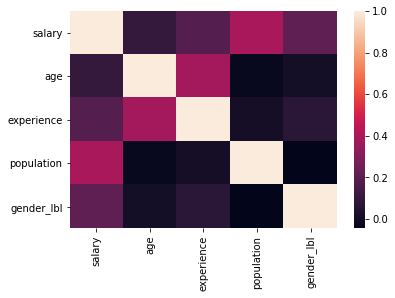

In [ ]:
# Посмотрим на зависимости между признаками
heatmap(
    data_merged[['salary', 
                 'age', 
                 'experience', 
                 'population', 
                 'gender_lbl']
                ].corr());

Как видно, самая сильная зависимость уровня ожиданий - от численности населения города проживания (в крупных городах ожидания явно выше). Возраст и опыт - сильно скоррелированы

In [ ]:
# Добавим фиктивные переменные к датасету из наименований позиций
# при помощи метода "One-hot encoding"
data_dummy = pd.get_dummies(data_merged.drop(['city', 'gender'], axis=1))
data_dummy.head()

,age,salary,experience,population,gender_lbl,position_Администратор,position_Клиентский менеджер,position_Коммерческий директор,position_Менеджер по продажам,position_Менеджер по развитию,position_Продавец-консультант,position_Региональный менеджер,position_Руководитель продаж,position_Супервайзер,position_Территориальный менеджер,position_Торговый представитель,position_Управляющий магазином
0,32,70,6,4848742,1,0,1,0,0,0,0,0,0,0,0,0,0
1,29,75,5,11514330,1,0,0,0,0,0,0,1,0,0,0,0,0
2,46,70,13,100969,1,0,0,0,0,0,0,1,0,0,0,0,0
3,20,70,11,11514330,1,0,0,0,1,0,0,0,0,0,0,0,0
4,33,55,10,11514330,1,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_dummy.shape

(9894, 17)

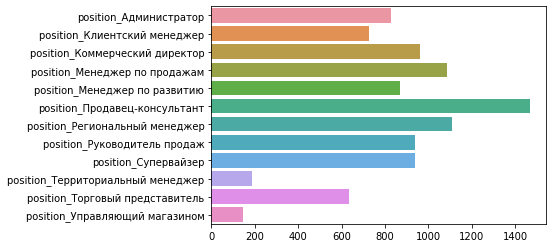

In [ ]:
# Посмотрим на частые позиции
db = data_dummy.drop(['age',	'salary',	'experience',	
                       'population',	'gender_lbl'], axis=1)

sns.barplot(x = db.sum(), 
            y = db.sum().index);

In [ ]:
def transliterate(name):
   """
   Транслитерация наименований должностей
   """
   # Слоаврь с заменами
   slovar = {'а':'a','б':'b','в':'v','г':'g','д':'d','е':'e','ё':'e',
      'ж':'zh','з':'z','и':'i','й':'i','к':'k','л':'l','м':'m','н':'n',
      'о':'o','п':'p','р':'r','с':'s','т':'t','у':'u','ф':'f','х':'h',
      'ц':'c','ч':'cz','ш':'sh','щ':'scz','ъ':'','ы':'y','ь':'','э':'e',
      'ю':'u','я':'ja', 'А':'A','Б':'B','В':'V','Г':'G','Д':'D','Е':'E','Ё':'E',
      'Ж':'ZH','З':'Z','И':'I','Й':'I','К':'K','Л':'L','М':'M','Н':'N',
      'О':'O','П':'P','Р':'R','С':'S','Т':'T','У':'U','Ф':'F','Х':'H',
      'Ц':'C','Ч':'CZ','Ш':'SH','Щ':'SCH','Ъ':'','Ы':'y','Ь':'','Э':'E',
      'Ю':'U','Я':'YA',',':'','?':'',' ':'_','~':'','!':'','@':'','#':'',
      '$':'','%':'','^':'','&':'','*':'','(':'',')':'','-':'','=':'','+':'',
      ':':'',';':'','<':'','>':'','\'':'','"':'','\\':'','/':'','№':'',
      '[':'',']':'','{':'','}':'','ґ':'','ї':'', 'є':'','Ґ':'g','Ї':'i',
      'Є':'e', '—':''}
        
   # Циклически заменяем все буквы в строке
   for key in slovar:
      name = name.replace(key, slovar[key])
   return name

In [ ]:
# Заменим наименования на кирилице латиницей
new_names = []

for name in data_dummy.columns:
  new_name = transliterate(name)
  new_names.append(new_name)

print(new_names)

['age', 'salary', 'experience', 'population', 'gender_lbl', 'position_Administrator', 'position_Klientskii_menedzher', 'position_Kommerczeskii_direktor', 'position_Menedzher_po_prodazham', 'position_Menedzher_po_razvitiu', 'position_Prodaveckonsultant', 'position_Regionalnyi_menedzher', 'position_Rukovoditel_prodazh', 'position_Supervaizer', 'position_Territorialnyi_menedzher', 'position_Torgovyi_predstavitel', 'position_Upravljausczii_magazinom']


In [ ]:
data_dummy.columns = new_names
data_dummy.head()

,age,salary,experience,population,gender_lbl,position_Administrator,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Supervaizer,position_Territorialnyi_menedzher,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom
0,32,70,6,4848742,1,0,1,0,0,0,0,0,0,0,0,0,0
1,29,75,5,11514330,1,0,0,0,0,0,0,1,0,0,0,0,0
2,46,70,13,100969,1,0,0,0,0,0,0,1,0,0,0,0,0
3,20,70,11,11514330,1,0,0,0,1,0,0,0,0,0,0,0,0
4,33,55,10,11514330,1,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Сохраним подготовленные данные
data_dummy.to_excel(f'{wdir}/data_dummy2.xlsx')

In [ ]:
# Загрузим подготовленные данные
data_dummy = pd.read_excel(f'{wdir}/data_dummy2.xlsx')
data_dummy = data_dummy.drop('Unnamed: 0', axis=1)
data_dummy.head()

,age,salary,experience,population,gender_lbl,position_Administrator,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Supervaizer,position_Territorialnyi_menedzher,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom
0,32,70,6,4848742,1,0,1,0,0,0,0,0,0,0,0,0,0
1,29,75,5,11514330,1,0,0,0,0,0,0,1,0,0,0,0,0
2,46,70,13,100969,1,0,0,0,0,0,0,1,0,0,0,0,0
3,20,70,11,11514330,1,0,0,0,1,0,0,0,0,0,0,0,0
4,33,55,10,11514330,1,0,1,0,0,0,0,0,0,0,0,0,0


Посмотрим на зависимости между признаками

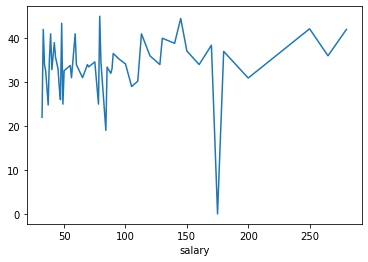

In [ ]:
# Возраст - доход
data_dummy.groupby('salary')['age'].mean().plot();

Наблюдается некоторый рост ожиданий при росте возраста, однако и молодые люди (до 30-ти лет), также претендуют на высокий доход

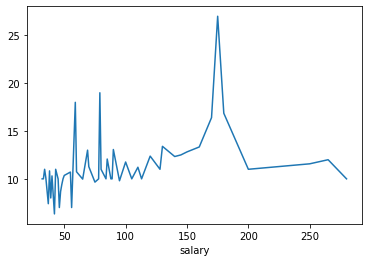

In [ ]:
# Опыт - доход
data_dummy.groupby('salary')['experience'].mean().plot();

Ожидаемо, что возраст и опыт скоррелированы, оценим это на стадии отбора признаков

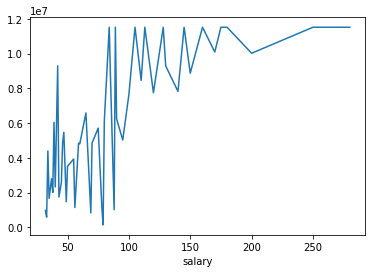

In [ ]:
# Размер города - доход
data_dummy.groupby('salary')['population'].mean().plot();

Численность города явно влияет на ожидания. Наиболее высокий уровень ЗП ожидают жители крупных городов. Среди малых городов ожидания ниже.

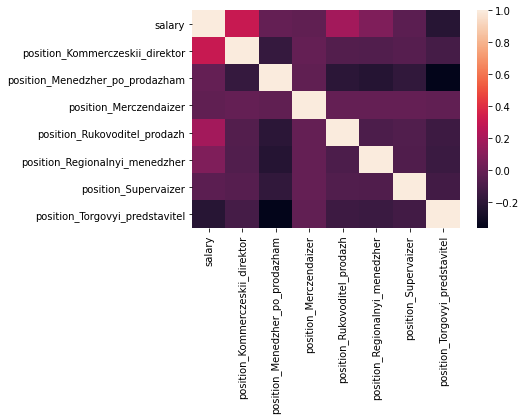

In [ ]:
heatmap(data_dummy[['salary',
                   'position_Kommerczeskii_direktor',
                   'position_Menedzher_po_prodazham',
                   'position_Merczendaizer',
                   'position_Rukovoditel_prodazh',
                   'position_Regionalnyi_menedzher',
                   'position_Supervaizer',
                   'position_Torgovyi_predstavitel'
                    ]].corr());

Также на примере мы видим явную зависимость между статусными позициями, такими как "Коммерческий директор" и "Руководитель продаж" и уровнем их ожиданий по доходу

## Baseline - тренируем наивную модель

"Always start with a stupid model, no exceptions..."

In [ ]:
# Фиксируем гиперпараметры
random_seed = 42
splits = 5

In [ ]:
def data_split(data):
  """Hold-out разбиение датасета на выборки
  для последующего использования в моделях"""
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, shuffle=True,
      random_state=random_seed)
  
  return X_train, X_test, y_train, y_test

Для baseline будем использовать простейшее предсказание на основе средний значений salary по каждой позиции

In [ ]:
def baseline(data):
  """Базовая модель на основе предсказания среднего 
  значения по признакам: возраст, пол, опыт, город"""
  X_train, X_test, y_train, y_test = data_split(data)
  X_train['salary'] = y_train
  y = data['salary'].values

  predict = []

  for index, row in pd.DataFrame(X_test).iterrows():
    results = X_train.query(f'age == {row[0]} \
                            and experience == {row[1]} \
                            and population == {row[2]} \
                            and gender_lbl == {row[3]} \
                            ')['salary'].mean()
    predict.append(results)
  

  predict = pd.DataFrame(predict)
  predict = predict.fillna(predict.mean())
  error = mae(y_test, predict)

  print('MAE:', error, 'MAPE:', error / data['salary'].mean())

  fig, ax = plt.subplots()
  ax.scatter(y_test, predict, edgecolors=(0,0,0))
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

MAE: 20.834741015266363 MAPE: 0.3250332011252626


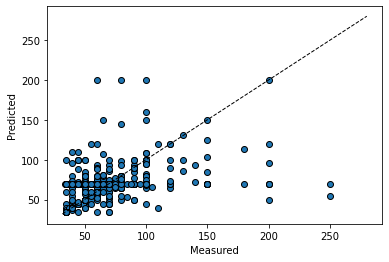

In [ ]:
baseline(data_dummy)

In [ ]:
def baseline2(data):
  """Базовая модель на основе предсказания среднего 
  значения по признакам: все признаки"""
  cat_data = data.iloc[:, :5]
  # Реверсия категориальных признаков для простоты работы с данными
  cat_data['position'] = pd.get_dummies(data.iloc[:, 5:]).idxmax(1)
  # Разбиение выборки
  X_train, X_test, y_train, y_test = data_split(cat_data)
  X_train['salary'] = y_train
  y = data['salary'].values

  predict = []

  for index, row in pd.DataFrame(X_test).iterrows():
    results = X_train.query(f'age == {row[0]} \
                            and experience == {row[1]} \
                            and population == {row[2]} \
                            and gender_lbl == {row[3]} \
                            and position == "{row[4]}" \
                            ')['salary'].mean()
    predict.append(results)
  

  predict = pd.DataFrame(predict)
  predict = predict.fillna(predict.mean())
  error = mae(y_test, predict)

  print('MAE:', error, 'MAPE:', error / data['salary'].mean())

  fig, ax = plt.subplots()
  ax.scatter(y_test, predict, edgecolors=(0,0,0))
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


MAE: 19.661227529918378 MAPE: 0.3067257575901195


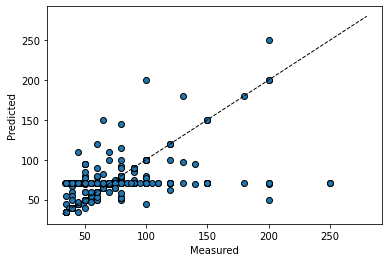

In [ ]:
# Усреднение по всем признакам датасета
baseline2(data_dummy)

Метрики `mae` и `mape` выберем в связи с их высокой интуитивностью, ведь все понимают, что ошибка модели в 1-3 тыс.р - приемлемый результат, а в 5-10 тыс.р при средней ожидаемой зарплате в 65 тыс.р. - это достаточно много.

## Подготовка и построение модели

### Разбиение выборки и кросс-валидация

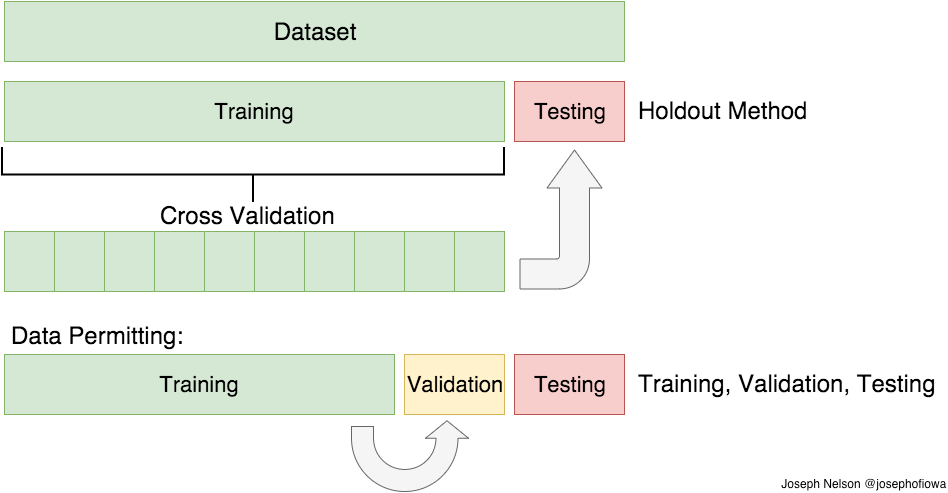

Обучение модели на одной разбивке данных, особенно при небольшом их количестве, как в нашем случае - является методологической ошибкой. Поэтому, сделаем разбиение данных на фолды и кросс-валидацию

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
def cross_val(data, model):
  """Скоринг кросс-валидации данных"""
  mean_salary = data['salary'].mean()
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values

  cv_score = cross_val_score(model, 
                              X, y, 
                              cv=splits,
                              scoring='neg_mean_absolute_error',
                              n_jobs=-1)
  print(
      'MAE:', abs(cv_score.mean()),
      'MAPE', abs(cv_score.mean()) / mean_salary
  ) 

In [ ]:
# Начнем с модели линейной регрессии
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
cross_val(data_dummy, model_lr)

MAE: 18.93186721669627 MAPE 0.28175676029180635


In [ ]:
def cross_val_fig(data, model):
  """Визуализация прогноза кросс-валидации данных"""
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values

  predicted = cross_val_predict(model, 
                                X, y, 
                                cv=splits)
  
  error = mae(y, predicted)
  # cross_val_predict возвращает массив размерности `y`, где каждое значение
  # где каждый прогноз получен методом кросс-валидации:
  
  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y, predicted, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  
  print('MAE:', error, 'MAPE:', error / data['salary'].mean())
  plt.show()

MAE: 18.93185336176646 MAPE: 0.28175655409343764


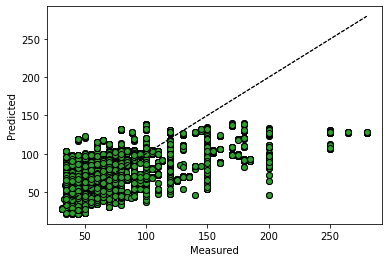

In [ ]:
model_lr = LinearRegression()
# Метрики с использованием кросс-валидации
cross_val_fig(data_dummy, model_lr)

Приближение линией - не работает. На графике видно, что аппроксимирующей способности модели линейной регрессии недостаточно, чтобы описать зависимости в данных. Результат немногим лучше Baseline. Требуется усложнение модели

### Сравнительное тестирование различных моделей с базовыми параметрами

In [ ]:
def review_models(data):
  """Обзор метрики MAE / MAPE некоторых моделей на
  стандартных настройках"""

  mean_salary = data['salary'].mean()

  X_train, X_test, y_train, y_test = data_split(data)
  
  # CatBoost
  model_catboost = CatBoostRegressor(random_state=random_seed)
  model_catboost.fit(X_train, y_train, silent=True)
  y_catboost = model_catboost.predict(X_test)
  mae_catboost = mae(y_test, y_catboost)

  # Lightgbm
  model_lightgbm = LGBMRegressor(random_state=random_seed)
  model_lightgbm.fit(X_train, y_train)
  y_lightgbm = model_lightgbm.predict(X_test)
  mae_lightgbm = mae(y_test, y_lightgbm)

  # XGBRegressor
  model_xgb = XGBRegressor(random_state=random_seed)
  model_xgb.fit(X_train, y_train)
  y_xgb = model_xgb.predict(X_test)
  mae_xgb = mae(y_test, y_xgb)

  # RandomForest
  model_rf = RandomForestRegressor(random_state=random_seed)
  model_rf.fit(X_train, y_train)
  y_rf = model_rf.predict(X_test)
  mae_rf = mae(y_test, y_rf)

  #ExtraTrees
  model_etr = ExtraTreesRegressor(random_state=random_seed)
  model_etr.fit(X_train, y_train)
  y_etr = model_etr.predict(X_test)
  mae_etr = mae(y_test, y_etr)
  
  # Таблица итогового сравнения
  x = PrettyTable()
  x.field_names = ["Regressor", "MAE", "MAPE"]
  x.add_row(["CatBoost", mae_catboost, mae_catboost / mean_salary])
  x.add_row(["LGBM", mae_lightgbm, mae_lightgbm / mean_salary])
  x.add_row(["RandomForest", mae_rf, mae_rf / mean_salary])
  x.add_row(["XGBoost", mae_xgb, mae_xgb / mean_salary])
  x.add_row(["ExtraTrees", mae_etr, mae_etr / mean_salary])

  print(x.get_string(sortby="MAPE"))

In [ ]:
# Обзор результатов
warnings.filterwarnings('ignore')
review_models(data_dummy)

[08:53:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
+--------------+--------------------+----------------------+
|  Regressor   |        MAE         |         MAPE         |
+--------------+--------------------+----------------------+
|  ExtraTrees  | 2.8847661460936305 | 0.04293302684935376  |
| RandomForest | 3.586764954282548  | 0.053380644491082326 |
|   CatBoost   | 9.090728660179959  |  0.1352943281645916  |
|     LGBM     | 10.829363897719112 | 0.16116986522868967  |
|   XGBoost    | 14.704130347176234 | 0.21883674135824557  |
+--------------+--------------------+----------------------+


Все модели показывают сходный результат на базовых параметрах

### Отбор признаков

In [ ]:
# Посмотрим на значимость признаков для модели


def feature_importance(data):  
  """Оценка значимости признаков"""

  X_train, X_test, y_train, y_test = data_split(data)

  #ExtraTrees
  model_etr = ExtraTreesRegressor(random_state=random_seed)
  model_etr.fit(X_train, y_train)

  # Значения признаков
  r = permutation_importance(model_etr, 
                            X_test, y_test,
                            n_repeats=3,
                            random_state=random_seed)

  for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
      print(f"{data.columns[i]:<8}",
            f"{r.importances_mean[i]:.3f}",
            f" +/- {r.importances_std[i]:.3f}")

In [ ]:
feature_importance(data_dummy)

experience 1.058  +/- 0.053
position_Klientskii_menedzher 0.469  +/- 0.041
age      0.456  +/- 0.019
population 0.381  +/- 0.009
salary   0.324  +/- 0.013
position_Regionalnyi_menedzher 0.204  +/- 0.012
position_Menedzher_po_razvitiu 0.141  +/- 0.007
position_Menedzher_po_prodazham 0.112  +/- 0.003
position_Prodaveckonsultant 0.106  +/- 0.011
position_Administrator 0.059  +/- 0.006
gender_lbl 0.057  +/- 0.005
position_Territorialnyi_menedzher 0.019  +/- 0.004
position_Rukovoditel_prodazh 0.011  +/- 0.001
position_Supervaizer 0.004  +/- 0.001
position_Torgovyi_predstavitel 0.000  +/- 0.000


In [ ]:
df = data_dummy.copy()
cols = df.columns.tolist()

In [ ]:
for i in cols[2:]:
  if i != 'salary':
    print(f'Features: {i}')
    review_models(df.loc[:, :i])

Features: experience
[08:55:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
+--------------+--------------------+---------------------+
|  Regressor   |        MAE         |         MAPE        |
+--------------+--------------------+---------------------+
|  ExtraTrees  |  19.1845205954772  | 0.28551691752655145 |
| RandomForest | 19.293819144022276 | 0.28714357191780443 |
|   CatBoost   | 20.13556461277711  |  0.2996709931991828 |
|     LGBM     | 20.635728821749506 | 0.30711477280744526 |
|   XGBoost    | 22.134823321573297 | 0.32942530376601414 |
+--------------+--------------------+---------------------+
Features: population
[08:55:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
+--------------+--------------------+---------------------+
|  Regressor   |        MAE         |         MAPE        |
+--------------+--------------------+-------

### Обучение модели ExtraTrees с оптимизацией гиперпараметров

In [ ]:
# GridSearchCV обладает встроенными метриками и позволяет
# осуществлять кросс-валидацию


def train_extra_trees(data):
  """Обучает модель регрессии ExtraTrees"""
  
  mean_salary = data['salary'].mean()
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values
  X_train, X_test, y_train, y_test = data_split(data)
  
  # Описание модели
  model = ExtraTreesRegressor(random_state=random_seed)
  
  # Оптимизатор гиперпараметров
  params = {
      # 'criterion': ['mae', 'mse'],
      'n_estimators': [20, 30, 50, 100, 250],
      # 'min_samples_split': [1, 2, 4, 6, 8],
      'min_samples_leaf': [1, 2, 4, 6, 8],
      # 'min_weight_fraction_leaf': [0.0, 0.1],
      # 'min_impurity_decrease': [0.0, 0.1],
      # 'min_impurity_split': [0.0, 0.1],
      # 'bootstrap': ['True', 'False'],
      # 'ccp_alpha': [0.0, 0.1]
      }

  clf = GridSearchCV(model, 
                     params) # Кросс-валидация на n-folds
  
  search = clf.fit(X, y)
  best_params = search.best_params_
  print('Лучшие параметры:', best_params)
  print('Обучение модели на лучших параметрах...')

  # Обучение модели с оптимальными гиперпараметрами
  best_model = ExtraTreesRegressor(
      random_state=random_seed,
      criterion='mae',
      # n_estimators=250,
      n_estimators=best_params['n_estimators'],
      # min_samples_split=best_params['min_samples_split'],
      min_samples_leaf=best_params['min_samples_leaf'],
      # min_weight_fraction_leaf=best_params['min_weight_fraction_leaf'],
      # min_impurity_decrease=best_params['min_impurity_decrease'],
      # min_impurity_split=best_params['min_impurity_split'],
      # bootstrap=best_params['bootstrap'],
      # ccp_alpha=best_params['ccp_alpha'],
      n_jobs=-1)
  
  best_model.fit(X_train, y_train)
  
  # Предсказание на основании обученной модели
  y_pred = best_model.predict(X_test)

  # Метрика качества mse
  error = mae(y_test, y_pred)
  
  print('MAE:', error, 'MAPE:', error / mean_salary)

  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y_test, y_pred, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  plt.show()

  return best_model

Лучшие параметры: {'min_samples_leaf': 2, 'n_estimators': 250}
Обучение модели на лучших параметрах...
MAE: 3.2441344113188477 MAPE: 0.04828138668109007


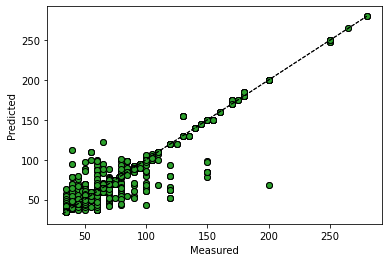

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=250, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [ ]:
train_extra_trees(data_dummy)

### Обучение модели XGBR с оптимизацией гиперпараметров

In [ ]:
def train_xgbr(data):
  """Обучает модель регрессии XGBR"""
  
  mean_salary = data['salary'].mean()
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values
  X_train, X_test, y_train, y_test = data_split(data)
  
  # Описание модели
  model = XGBRegressor(random_state=random_seed)
  
  # Оптимизатор гиперпараметров
  params = {
      'n_estimators': [20, 30, 50, 100, 1000],
      # 'max_depth': [int],
      'learning_rate': [0.1, 1, 1.2],
      'verbosity': [0.1, 1, 1.2],
      'objective': ['reg:squarederror'],
      'booster': ['gbtree', 'gblinear', 'dart'],
      # 'tree_method': [str],
      # 'gamma': [float],
      # 'min_child_weight': [float],
      'colsample_bytree': [0.3, 1],
      # 'colsample_bylevel': [float],
      # 'colsample_bynode': [],
      # 'reg_alpha': [0.2],
      # 'reg_lambda': [float],
      # 'scale_pos_weight': [float],
      'base_score': [0.1, 0.5, 1]
      }

  clf = GridSearchCV(model, 
                     params) # Кросс-валидация на n-folds
  
  search = clf.fit(X, y)
  best_params = search.best_params_
  print('Лучшие параметры:', best_params)
  print('Обучение модели на лучших параметрах...')

  # Обучение модели с оптимальными гиперпараметрами
  best_model = XGBRegressor(
      random_state=random_seed,
      n_estimators=best_params['n_estimators'],
      # max_depth=best_params['max_depth'],
      learning_rate=best_params['learning_rate'],
      verbosity=best_params['verbosity'],
      objective=best_params['objective'],
      booster=best_params['booster'],
      # tree_method=best_params['tree_method'],
      # gamma=best_params['gamma'],
      # min_child_weight=best_params['min_child_weight'],
      colsample_bytree=best_params['colsample_bytree'],
      # colsample_bylevel=best_params['colsample_bylevel'],
      # colsample_bynode=best_params['colsample_bynode'],
      # reg_alpha=best_params['reg_alpha'],
      # reg_lambda=best_params['reg_lambda'],
      # scale_pos_weight=best_params['scale_pos_weight'],
      base_score=best_params['base_score']
      )
  
  best_model.fit(X_train, y_train)
  
  # Предсказание на основании обученной модели
  y_pred = best_model.predict(X_test)

  # Метрика качества mse
  error = mae(y_test, y_pred)
  
  print('MAE:', error, 'MAPE:', error / mean_salary)

  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y_test, y_pred, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  plt.show()

  return best_model

Лучшие параметры: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bytree': 1, 'learning_rate': 1, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'verbosity': 1}
Обучение модели на лучших параметрах...
MAE: 6.38350814734522 MAPE: 0.09500365464776415


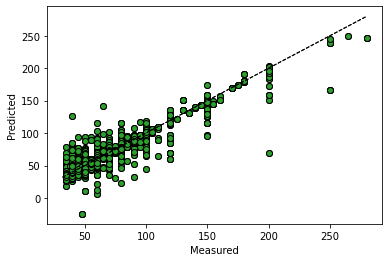

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
train_xgbr(data_dummy)

### Обучение модели LGBM с оптимизацией гиперпараметров

In [ ]:
def train_lgbm(data):
  """Обучает модель регрессии LGBM"""
  
  mean_salary = data['salary'].mean()
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values
  X_train, X_test, y_train, y_test = data_split(data)
  
  # Описание модели
  model = LGBMRegressor(random_state=random_seed)
  
  # Оптимизатор гиперпараметров
  params = {
      'boosting_type': ['gbdt'], 
      'num_leaves': [5, 10, 15], 
      'max_depth': [-1], 
      'learning_rate': [0.05, 0.1, 1], 
      'n_estimators': [600], 
      'subsample_for_bin': [200000], 
      'objective': ['regression'], 
      'class_weight': [None], 
      'min_split_gain': [0.0], 
      'min_child_weight': [1e-3], 
      'min_child_samples': [3],
      'subsample': [1.0], 
      'subsample_freq': [0], 
      'colsample_bytree': [1.0], 
      'reg_alpha': [0.0], 
      'reg_lambda': [0.0],
      'n_jobs': [-1], 
      'importance_type': ['split']
  }

  clf = GridSearchCV(model, 
                     params) # Кросс-валидация на n-folds
  
  search = clf.fit(X, y)
  best_params = search.best_params_
  print('Лучшие параметры:', best_params)
  print('Обучение модели на лучших параметрах...')

  # Обучение модели с оптимальными гиперпараметрами
  best_model = LGBMRegressor(
      boosting_type=best_params['boosting_type'], 
      num_leaves=best_params['num_leaves'], 
      max_depth=best_params['max_depth'], 
      learning_rate=best_params['learning_rate'], 
      n_estimators=best_params['n_estimators'], 
      subsample_for_bin=best_params['subsample_for_bin'], 
      objective=best_params['objective'], 
      class_weight=best_params['class_weight'], 
      min_split_gain=best_params['min_split_gain'], 
      min_child_weight=best_params['min_child_weight'], 
      min_child_samples=best_params['min_child_samples'], 
      subsample=best_params['subsample'], 
      subsample_freq=best_params['subsample_freq'], 
      colsample_bytree=best_params['colsample_bytree'], 
      reg_alpha=best_params['reg_alpha'], 
      reg_lambda=best_params['reg_lambda'], 
      random_state=random_seed, 
      n_jobs=- 1, 
      silent=True, 
      importance_type=best_params['importance_type']
  )
  
  best_model.fit(X_train, y_train)
  
  # Предсказание на основании обученной модели
  y_pred = best_model.predict(X_test)

  # Метрика качества mse
  error = mae(y_test, y_pred)
  
  print('MAE:', error, 'MAPE:', error / mean_salary)

  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y_test, y_pred, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  plt.show()

  return best_model

Лучшие параметры: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 1, 'max_depth': -1, 'min_child_samples': 3, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 600, 'n_jobs': -1, 'num_leaves': 10, 'objective': 'regression', 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Обучение модели на лучших параметрах...
MAE: 3.8726356114071456 MAPE: 0.05763516356688071


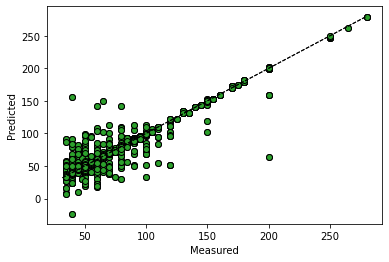

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=1, max_depth=-1,
              min_child_samples=3, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=600, n_jobs=-1, num_leaves=10,
              objective='regression', random_state=42, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
train_lgbm(data_dummy)

### Обучение модели CatBoost с оптимизацией гиперпараметров

In [ ]:
def train_catboost(data):
  """Обучает модель регрессии CBR"""
  
  mean_salary = data['salary'].mean()
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values
  X_train, X_test, y_train, y_test = data_split(data)
  
  # Описание модели
  model = CatBoostRegressor(random_state=random_seed)
  
  # Оптимизатор гиперпараметров
  params = {
      'iterations': [1000], 
      'learning_rate': [0.1],
      # 'depth': None, 
      'l2_leaf_reg': [3.0],
      # 'model_size_reg': None, 
      'rsm': [1],
      # 'loss_function': ['MAE'],
      # 'border_count': None,
      # 'feature_border_type': None,
      # 'per_float_feature_quantization': None,
      # 'input_borders': None, 
      # 'output_borders': None,
      'fold_permutation_block': [1], 
      # 'od_pval': None,
      # 'od_wait': None, 
      # 'od_type': None,
      # 'nan_mode': None,
      # 'counter_calc_method': [],
      'leaf_estimation_iterations': [10],
      'leaf_estimation_method': ['Gradient'],
      # 'thread_count': None,
      'use_best_model': [False],
      'best_model_min_trees': [2, 10, 50],
      # 'verbose': None,
      # 'logging_level': None,
      # 'metric_period': None,
      # 'ctr_leaf_count_limit': None,
      # 'store_all_simple_ctr': None,
      # 'max_ctr_complexity': None,
      # 'has_time': None,
      # 'allow_const_label': None,
      'random_strength': [1.0],
      # 'name': None,
      # 'ignored_features': None,
      # 'train_dir': None,
      # 'custom_metric': None,
      'eval_metric': ['MAE'],
      'bagging_temperature': [0.1],
      # 'save_snapshot': None,
      # 'snapshot_file': None,
      # 'snapshot_interval': None,
      # 'fold_len_multiplier': None,
      # 'used_ram_limit': None,
      # 'gpu_ram_part': None,
      # 'pinned_memory_size': None,
      # 'allow_writing_files': None,
      # 'final_ctr_computation_mode': None,
      # 'approx_on_full_history': None,
      'boosting_type': ['Plain'],
      # 'simple_ctr': None,
      # 'combinations_ctr': None,
      # 'per_feature_ctr': None,
      # 'ctr_target_border_count': None,
      # 'task_type': None,
      # 'device_config': None,                        
      # 'devices': None,
      'bootstrap_type': ['MVS'],
      'subsample': [0.5],
      'sampling_unit': ['Object'],
      # 'dev_score_calc_obj_block_size': None,
      # 'max_depth': None,
      # 'colsample_bylevel': None,
      # 'reg_lambda': None,
      # 'objective': None,
      # 'eta': None,
      # 'max_bin': None,
      # 'gpu_cat_features_storage': None,
      # 'data_partition': None,
      # 'metadata': None,
      # 'early_stopping_rounds': None,
      # 'cat_features': None,
      'grow_policy': ['SymmetricTree'],
      'min_child_samples': [1],
      # 'max_leaves': None,
      # 'num_leaves': [5, 30, 50],
      # 'score_function': None,
      'leaf_estimation_backtracking': ['No', 'Any other value'],
      # 'ctr_history_unit': None,
      # 'monotone_constraints': None,
      # 'feature_weights': None,
      # 'penalties_coefficient': None,
      # 'first_feature_use_penalties': None,
      # 'model_shrink_rate': None,
      # 'model_shrink_mode': None,
      # 'langevin': None,
      # 'diffusion_temperature': None,
      # 'boost_from_average': None
  }

  clf = GridSearchCV(model, 
                     params) # Кросс-валидация на n-folds
  
  search = clf.fit(X, y)
  best_params = search.best_params_
  print('Лучшие параметры:', best_params)
  print('Обучение модели на лучших параметрах...')

  # Обучение модели с оптимальными гиперпараметрами
  best_model = CatBoostRegressor(
      iterations=best_params['iterations'], 
      learning_rate=best_params['learning_rate'],
      # depth=best_params['depth'], 
      l2_leaf_reg=best_params['l2_leaf_reg'],
      # model_size_reg=best_params['model_size_reg'], 
      rsm=best_params['rsm'],
      # loss_function=best_params['loss_function'], 
      # border_count=best_params['border_count'],
      # feature_border_type=best_params['feature_border_type'],
      # per_float_feature_quantization=best_params['per_float_feature_quantization'],
      # input_borders=best_params['input_borders'], 
      # output_borders=best_params['output_borders'],
      fold_permutation_block=best_params['fold_permutation_block'], 
      # od_pval=best_params['od_pval'],
      # od_wait=best_params['od_wait'], 
      # od_type=best_params['od_type'],
      # nan_mode=best_params['nan_mode'],
      # counter_calc_method=best_params['counter_calc_method'],
      leaf_estimation_iterations=best_params['leaf_estimation_iterations'],
      leaf_estimation_method=best_params['leaf_estimation_method'],
      # thread_count=best_params['thread_count'],
      use_best_model=best_params['use_best_model'],
      best_model_min_trees=best_params['best_model_min_trees'],
      # verbose=best_params['verbose'],
      silent=True,
      # logging_level=best_params['logging_level'],
      # metric_period=best_params['metric_period'],
      # ctr_leaf_count_limit=best_params['ctr_leaf_count_limit'],
      # store_all_simple_ctr=best_params['store_all_simple_ctr'],
      # max_ctr_complexity=best_params['max_ctr_complexity'],
      # has_time=best_params['has_time'],
      # allow_const_label=best_params['allow_const_label'],
      random_strength=best_params['random_strength'],
      # name=best_params['name'],
      # ignored_features=best_params['ignored_features'],
      # train_dir=best_params['train_dir'],
      # custom_metric=best_params['custom_metric'],
      eval_metric=best_params['eval_metric'],
      bagging_temperature=best_params['bagging_temperature'],
      # save_snapshot=best_params['save_snapshot'],
      # snapshot_file=best_params['snapshot_file'],
      # snapshot_interval=best_params['snapshot_interval'],
      # fold_len_multiplier=best_params['fold_len_multiplier'],
      # used_ram_limit=best_params['used_ram_limit'],
      # gpu_ram_part=best_params['gpu_ram_part'],
      # pinned_memory_size=best_params['pinned_memory_size'],
      # allow_writing_files=best_params['allow_writing_files'],
      # final_ctr_computation_mode=best_params['final_ctr_computation_mode'],
      # approx_on_full_history=best_params['approx_on_full_history'],
      boosting_type=best_params['boosting_type'],
      # simple_ctr=best_params['simple_ctr'],
      # combinations_ctr=best_params['combinations_ctr'],
      # per_feature_ctr=best_params['per_feature_ctr'],
      # ctr_target_border_count=best_params['ctr_target_border_count'],
      # task_type=best_params['task_type'],
      # device_config=best_params['device_config'],                        
      # devices=best_params['devices'],
      bootstrap_type=best_params['bootstrap_type'],
      subsample=best_params['subsample'],
      sampling_unit=best_params['sampling_unit'],
      # dev_score_calc_obj_block_size=best_params['dev_score_calc_obj_block_size'],
      # max_depth=best_params['max_depth'],
      # num_trees=best_params['num_trees'],
      # colsample_bylevel=best_params['colsample_bylevel'],
      random_state=random_seed,
      # reg_lambda=best_params['reg_lambda'],
      # objective=best_params['objective'],
      # eta=best_params['eta'],
      # max_bin=best_params['max_bin'],
      # gpu_cat_features_storage=best_params['gpu_cat_features_storage'],
      # data_partition=best_params['data_partition'],
      # metadata=best_params['metadata'],
      # early_stopping_rounds=best_params['early_stopping_rounds'],
      # cat_features=best_params['cat_features'],
      grow_policy=best_params['grow_policy'],
      min_child_samples=best_params['min_child_samples'],
      # max_leaves=best_params['max_leaves'],
      # num_leaves=best_params['num_leaves'],
      # score_function=best_params['score_function'],
      leaf_estimation_backtracking=best_params['leaf_estimation_backtracking'],
      # ctr_history_unit=best_params['ctr_history_unit'],
      # monotone_constraints=best_params['monotone_constraints'],
      # feature_weights=best_params['feature_weights'],
      # penalties_coefficient=best_params['penalties_coefficient'],
      # first_feature_use_penalties=best_params['first_feature_use_penalties'],
      # model_shrink_rate=best_params['model_shrink_rate'],
      # model_shrink_mode=best_params['model_shrink_mode'],
      # langevin=best_params['langevin'],
      # diffusion_temperature=best_params['diffusion_temperature'],
      # boost_from_average=best_params['boost_from_average']
  )
  
  best_model.fit(X_train, y_train)
  
  # Предсказание на основании обученной модели
  y_pred = best_model.predict(X_test)

  # Метрика качества mse
  error = mae(y_test, y_pred)
  
  print('MAE:', error, 'MAPE:', error / mean_salary)

  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y_test, y_pred, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  plt.show()

  return best_model

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 20.5981333	total: 20.7ms	remaining: 4.13s
5:	learn: 20.0017318	total: 26ms	remaining: 4.31s
6:	learn: 19.5021725	total: 32.5ms	remaining: 4.61s
7:	learn: 19.0957820	total: 35.5ms	remaining: 4.4s
8:	learn: 18.7287704	total: 38.3ms	remaining: 4.22s
9:	learn: 18.3972673	total: 41.3ms	remaining: 4.08s
10:	learn: 18.0484739	total: 44.1ms	remaining: 3.97s
11:	learn: 17.7715307	total: 48.2ms	remaining: 3.97s
12:	learn: 17.5436890	total: 53.3ms	remaining: 4.05s
13:	learn: 17.3168088	total: 56.3ms	remaining: 3.96s
14:	learn: 17.0947685	total: 59.2ms	remaining: 3.88s
15:	learn: 16.8847060	total: 62.2ms	remaining: 3.83s
16:	learn: 16.7458074	total: 65ms	remaining: 3.76s
17:	learn: 16.5798188	total: 67.8ms	remaining: 3.7s
18:	learn: 16.4668727	total: 70.4ms	remaining: 3.63s
19:	learn: 16.3755798	total: 73.2ms	remaining: 3.58s
20:	learn: 16.2527945	total: 75.8ms	remaining: 3.53s
21:	learn: 16.1529282	total: 78.6ms	remaini

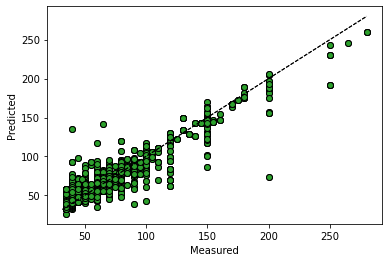

In [ ]:
train_catboost(data_dummy)

### Стэкинг

In [ ]:
def stack(data):
  """Стэкинг наиболее сильных из слабых моделей"""
  
  mean_salary = data['salary'].mean()
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values
  X_train, X_test, y_train, y_test = data_split(data)

  estimators = [
      ('ETR', ExtraTreesRegressor(
          bootstrap=False, ccp_alpha=0.0, criterion='mae',
          max_depth=None, max_features='auto', max_leaf_nodes=None,
          max_samples=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=2,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1000, n_jobs=-1, oob_score=False,
          random_state=42, verbose=0, warm_start=False
      )),
      # ('XGBR', XGBRegressor(
      #     base_score=1, booster='dart', colsample_bylevel=1,
      #     colsample_bynode=1, colsample_bytree=1, gamma=0,
      #     importance_type='gain', learning_rate=0.1, max_delta_step=0,
      #     max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
      #     n_jobs=-1, nthread=None, objective='reg:squarederror',
      #     random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
      #     seed=None, silent=None, subsample=1, verbosity=1
      # )),
      ('LGBM', LGBMRegressor(
          boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
          importance_type='split', learning_rate=1, max_depth=-1,
          min_child_samples=3, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=600, n_jobs=-1, num_leaves=10,
          objective='regression', random_state=42, reg_alpha=0.0,
          reg_lambda=0.0, silent=True, subsample=1.0,
          subsample_for_bin=200000, subsample_freq=0
      )),
      ('CATR', CatBoostRegressor(random_state=random_seed, silent=True,
          boosting_type='Plain', bootstrap_type='MVS', iterations=1000, 
          l2_leaf_reg=3.0, leaf_estimation_iterations=5, 
          leaf_estimation_method='Gradient', learning_rate=0.1
      ))
  ]

  model_stack = StackingRegressor(
      estimators=estimators,
      final_estimator=ExtraTreesRegressor(
          bootstrap=False, ccp_alpha=0.0, criterion='mae',
          max_depth=None, max_features='auto', max_leaf_nodes=None,
          max_samples=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=2,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1000, n_jobs=-1, oob_score=False,
          random_state=42, verbose=0, warm_start=False
      )
  )
      
  model_stack.fit(X_train, y_train)
  y_pred = model_stack.predict(X_test)
  error = mae(y_test, y_pred)
  print('MAE:', error, 'MAPE:', error / mean_salary)

  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y_test, y_pred, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  plt.show()

MAE: 3.2314161192521476 MAPE: 0.048092104518472845


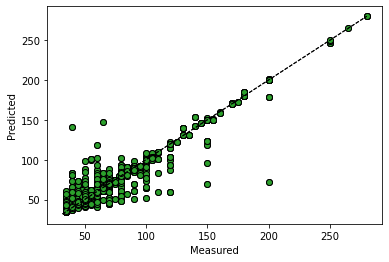

In [ ]:
stack(data_dummy)

## Построение признаков

Попробуем добавить в датасет новые данные на основе уже существующих, которые смогут привнести в наши данные новые зависимости

In [ ]:
data_dummy.columns

Index(['age', 'salary', 'experience', 'population', 'gender_lbl',
       'position_Administrator', 'position_Voditel', 'position_Kam',
       'position_Kassir', 'position_Kladovsczik',
       'position_Klientskii_menedzher', 'position_Kommerczeskii_direktor',
       'position_Kurer', 'position_Menedzher_po_zakupkam',
       'position_Menedzher_po_prodazham', 'position_Menedzher_po_razvitiu',
       'position_Merczendaizer', 'position_Operator',
       'position_Pomoscznik_menedzhera', 'position_Prodaveckonsultant',
       'position_Regionalnyi_menedzher', 'position_Rukovoditel_prodazh',
       'position_Specialist', 'position_Supervaizer',
       'position_Territorialnyi_menedzher', 'position_Tovaroved',
       'position_Torgovyi_predstavitel', 'position_Upravljausczii_magazinom'],
      dtype='object')

In [ ]:
data_dummy.columns[0:5]

Index(['age', 'salary', 'experience', 'population', 'gender_lbl'], dtype='object')

In [ ]:
data_dummy.columns[5:]

Index(['position_Administrator', 'position_Voditel', 'position_Kam',
       'position_Kassir', 'position_Kladovsczik',
       'position_Klientskii_menedzher', 'position_Kommerczeskii_direktor',
       'position_Kurer', 'position_Menedzher_po_zakupkam',
       'position_Menedzher_po_prodazham', 'position_Menedzher_po_razvitiu',
       'position_Merczendaizer', 'position_Operator',
       'position_Pomoscznik_menedzhera', 'position_Prodaveckonsultant',
       'position_Regionalnyi_menedzher', 'position_Rukovoditel_prodazh',
       'position_Specialist', 'position_Supervaizer',
       'position_Territorialnyi_menedzher', 'position_Tovaroved',
       'position_Torgovyi_predstavitel', 'position_Upravljausczii_magazinom'],
      dtype='object')

In [ ]:
def poly_features(data, n_deg):
  """Преобразует исх.данные в данные с полиномиальными
  признаками полинома n_deg - степени"""

  X = data[data.columns[0:5]].drop(['salary'], axis=1)
  y = data['salary'].values

  polynomial_features = PolynomialFeatures(degree=n_deg)
  X_poly = polynomial_features.fit_transform(X)
  poly_data = pd.DataFrame(X_poly)
  poly_data['salary'] = y

  for i in data.columns[5:]:
    poly_data[i] = data[i]

  print('Shape Of Data', poly_data.shape)
  return poly_data

Shape Of Data (9894, 28)
Лучшие параметры: {'min_samples_leaf': 2, 'n_estimators': 100}
Обучение модели на лучших параметрах...
MAE: 3.5701490651844363 MAPE: 0.05313335567228462


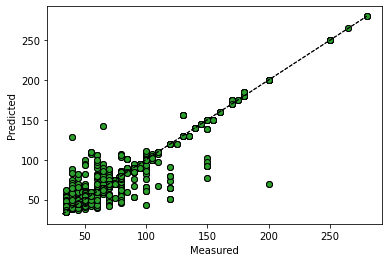

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [ ]:
# Обучение на данных с полиномиальными признаками (2 степени)
train_extra_trees(
    poly_features(data_dummy, 2)
)

Shape Of Data (9894, 28)
MAE: 3.2349151086407275 MAPE: 0.04814417882805559


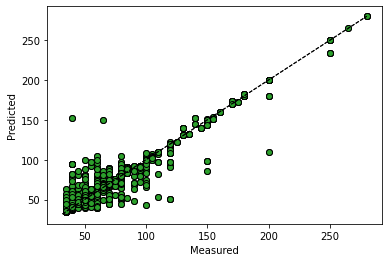

In [ ]:
# Обучение на данных с полиномиальными признаками (2 степени)
stack(
    poly_features(data_dummy, 2)
)

Shape Of Data (9894, 48)
MAE: 3.1365128852956037 MAPE: 0.04667969086509432


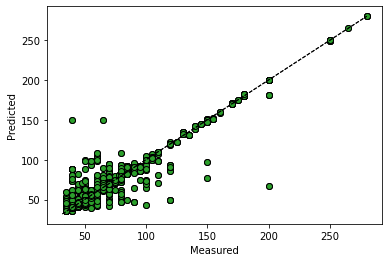

In [ ]:
# Обучение на данных с полиномиальными признаками (3 степени)
stack(
    poly_features(data_dummy, 3)
)

Приближение графиком полинома i-ой степени не работает, метрика максимально улучшается при использовании полинома 5-ой степени, `MAPE 4.67`

## Дорожная карта доработки

1) Повышение робастности модели за счет обогащения нескоррелированными данными, такими как:

- ключевые навыки
- тип предыдущего работодателя
- наличие водительских прав
- готовность к релокации и др.

2) Расширение тестируемых базовых алгоритмов

3) Использование NLP-алгоритмов для анализа резюме анкет

## Сериализация модели

In [ ]:
def serial_model(data):
  """Сохраняет модель регрессии в бинарный файл"""

  X = data.drop(['salary'], axis=1)
  y = data['salary'].values
  X_train, X_test, y_train, y_test = data_split(data)

  estimators = [
      ('ETR', ExtraTreesRegressor(
          bootstrap=False, ccp_alpha=0.0, criterion='mae',
          max_depth=None, max_features='auto', max_leaf_nodes=None,
          max_samples=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=2,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1000, n_jobs=-1, oob_score=False,
          random_state=42, verbose=0, warm_start=False
      )),
      ('LGBM', LGBMRegressor(
          boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
          importance_type='split', learning_rate=1, max_depth=-1,
          min_child_samples=3, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=600, n_jobs=-1, num_leaves=10,
          objective='regression', random_state=42, reg_alpha=0.0,
          reg_lambda=0.0, silent=True, subsample=1.0,
          subsample_for_bin=200000, subsample_freq=0
      )),
      ('CATR', CatBoostRegressor(random_state=random_seed, silent=True,
          boosting_type='Plain', bootstrap_type='MVS', iterations=1000, 
          l2_leaf_reg=3.0, leaf_estimation_iterations=5, 
          leaf_estimation_method='Gradient', learning_rate=0.1
      ))
  ]

  model = StackingRegressor(
      estimators=estimators,
      final_estimator=ExtraTreesRegressor(
          bootstrap=False, ccp_alpha=0.0, criterion='mae',
          max_depth=None, max_features='auto', max_leaf_nodes=None,
          max_samples=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=2,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1000, n_jobs=-1, oob_score=False,
          random_state=42, verbose=0, warm_start=False
      )
  )
      
  model.fit(X_train, y_train)
  

  # Сериализация модели
  with open(f'{wdir}/jsp_model.pkl', 'wb') as output:
    pickle.dump(model, output)

In [ ]:
serial_model(for_train)

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!ls

drive  jsp_model.pkl  requirements.txt	sample_data
